In [16]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
import os
import shutil 
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import cv2

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
from itertools import combinations

In [41]:
df = pd.read_csv('df_total.csv', index_col=0)
df['total_profit'] = df['total_given'] - df['total_taken']

df['gender'] = df['gender'].fillna('Мужской')
cols = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
       'Полнота верхней губы', 'Полнота нижней губы',
       'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
       'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
       'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
       'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
       ]

# for col in tqdm(cols):
#     df[col] = (df[col] - df[col].quantile(0.01)) / (df[col].quantile(0.99) - df[col].quantile(0.001))
    
df['Категория'] = df['fraud'].replace({True: 'Мошенник', False: 'Не мошенник'})
features = ['Асимметрия челюсти', 'Высота бровей', 'Наклон глаз',
           'Полнота верхней губы', 'Полнота нижней губы',
           'Асимметрия размера глаз', 'Ширина посадки глаз', 'Скулы',
           'Форма головы', 'Верхнее веко', 'Асимметрия брови', 'Наклон бровей',
           'Размер рта', 'Асимметрия наклона глаз', 'Асимметрия носа',
           'Размер глаз', 'Оттопыренность ушей', 'Ширина челюсти', 'Уголки рта',
           ]

anketas = ['source', 'childs', 'education', 'marital_status', 'job']

ga = ['age', 'gender']

In [42]:
df['Категория'].value_counts()


Не мошенник    32243
Мошенник        2845
Name: Категория, dtype: int64

In [43]:
df['total_profit'].sum()

80269680.82999998

<AxesSubplot:>

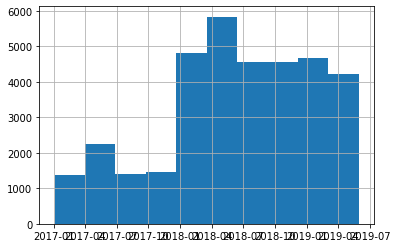

In [44]:
pd.to_datetime(df['loan_date']).hist()

In [45]:
df['Категория'] = df['Категория'].replace({'Не мошенник':0, 'Мошенник':1})
df['Категория'].value_counts()

0    32243
1     2845
Name: Категория, dtype: int64

In [46]:
from sklearn.model_selection import StratifiedKFold 

def train_model(df, cols, folds, iterations, depth, learning_rate ):
#                 depth, colsample_bylevel, subsample, bagging_temperature, random_strength, l2_leaf_reg):
    
    X = df[cols]
    cat_features = X.select_dtypes('object').columns.tolist()
    y = df['Категория']

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=6)
    staged_probas_df =  pd.DataFrame(np.zeros((X.shape[0],iterations)), index=X.index)

    for train_index, test_index in kf.split(X,y):
#         train_index = np.append(train_index, test_index[:2500])
        print(len(train_index), len(test_index))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = CatBoostClassifier(iterations=iterations, 
                                   depth=depth,
                                   eval_metric='AUC',
                                   learning_rate=learning_rate,
#                                    loss_function='Logloss',
                                   scale_pos_weight=3,
#                                    colsample_bylevel=0.5,
#                                    subsample=0.5,
# #                                    bagging_temperature=bagging_temperature,
#                                    random_strength=random_strength,
#                                    l2_leaf_reg=l2_leaf_reg,
#                                    boosting_type='Plain', # 'Plain'
                                   bootstrap_type='Bernoulli',# 'Bernoulli' Bayesian
#                                    max_ctr_complexity=2,
                                   task_type='CPU',
                                  )
        model.fit(
            X_train, y_train,
            eval_set = (X_test, y_test),
            cat_features=cat_features,
            verbose=False,
            plot=True,
            use_best_model=False
        );

        staged_probas = model.staged_predict_proba(X_test)
        for i, staged_proba in enumerate(staged_probas):
            staged_probas_df.iloc[test_index, i] = staged_proba[:,1]
        
    return staged_probas_df, model


def get_result_table(y_proba):
    df['y_proba'] = y_proba

    quantiles = []
    step = 0.2

    df['target'] = df['Категория'] == 1

    for i in np.arange(0, 1+step, step):
        if i > 1: i = 1
        quant = df['y_proba'].quantile(i)
        quantiles.append(quant)

    profit_abs = []
    loaners_amount = []
    good_bad = []

    for i, quant in enumerate(quantiles):
        if i == 0: quant = 0
        i_next = i + 1
        if i_next == len(quantiles): i_next = len(quantiles) - 1
        q = df[(df['y_proba'] >= quant) & (df['y_proba'] < quantiles[i_next])]
        profit_abs.append(round(pd.Series(q['total_given'] - q['total_taken']).sum()/1000000, 5))
        loaners_amount.append(q.shape[0])
        good_bad.append(q['target'].mean()*100)
        i_old = quantiles[i-1]

    print(quantiles)
    df2 = pd.DataFrame()
    df2['y proba'] = quantiles # np.append(np.arange(0, 0.1, 0.02), 
    df2['Количество людей'] = loaners_amount
    df2['Процент людей, %'] = df2['Количество людей'] * 100 / df.shape[0]
    df2['Процент мошенников в группе, %'] = good_bad
    df2['Прибыль, млн.р'] = np.array(profit_abs)

    return df2#.drop('Количество людей', axis=1)

In [47]:
staged_probas_df, model_KU = train_model(df=df, cols=features+anketas+ga,
                                          folds=4, iterations=500, \
                                          depth=4, learning_rate=0.1)

table = model_KU.get_feature_importance(prettified=True)
table.to_excel('tables/FEATURE_IMPORTANCE_features+anketas+ga.xls')
table

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/tmp/ipykernel_11249/1617969160.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/FEATURE_IMPORTANCE_features+anketas+ga.xls')


,Feature Id,Importances
0,source,9.872896
1,age,7.602981
2,Асимметрия носа,4.556449
3,Высота бровей,4.283936
4,Верхнее веко,4.174675
5,Наклон бровей,4.093435
6,Скулы,4.056042
7,Размер рта,4.054093
8,Уголки рта,3.965343
9,Асимметрия размера глаз,3.860808


In [48]:
table = get_result_table(staged_probas_df[449])
table.to_excel('tables/features+anketas+ga.xls')
table

[0.007471814685521921, 0.0760478274341962, 0.11943310591753781, 0.17607130643086127, 0.26786688742555226, 0.9003809872577438]


/tmp/ipykernel_11249/2698658785.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/features+anketas+ga.xls')


,y proba,Количество людей,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.007472,7018,20.00114,2.550584,20.27576
1,0.076048,7014,19.98974,3.763901,19.36821
2,0.119433,7021,20.00969,6.039026,16.77099
3,0.176071,7017,19.99829,9.605244,13.99829
4,0.267867,7017,19.99829,18.569189,9.85933
5,0.900381,0,0.00000,NaN,0.00000


/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


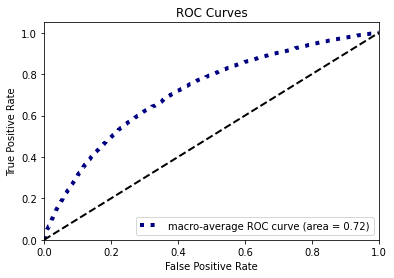

In [49]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([1-y_proba, y_proba])
skplt.metrics.plot_roc_curve(df['Категория'].astype(int).values, proba.T, curves=['macro'])
plt.show()

### Features + GA

In [50]:
staged_probas_df, model_KU = train_model(df=df, cols=features+ga,
                                          folds=4, iterations=500, \
                                          depth=4, learning_rate=0.1)

table = model_KU.get_feature_importance(prettified=True)
table.to_excel('tables/FEATURE_IMPORTANCE_features+ga.xls')
table

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/tmp/ipykernel_11249/376828380.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/FEATURE_IMPORTANCE_features+ga.xls')


,Feature Id,Importances
0,age,10.185940
1,Полнота нижней губы,5.515540
2,Наклон бровей,5.341562
3,Наклон глаз,5.336085
4,Высота бровей,5.030557
5,Оттопыренность ушей,5.011511
6,Асимметрия размера глаз,4.962885
7,Асимметрия носа,4.834749
8,Верхнее веко,4.794668
9,Уголки рта,4.693113


In [51]:
table = get_result_table(staged_probas_df[449])
table.to_excel('tables/features+ga.xls')
table

[0.003402229598993212, 0.09684350970842834, 0.1488862300578302, 0.20270834904194734, 0.2663166892876127, 0.7667557382754817]


/tmp/ipykernel_11249/4250072074.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/features+ga.xls')


,y proba,Количество людей,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.003402,7016,19.99544,3.435006,19.06522
1,0.096844,7019,20.00399,5.214418,17.97300
2,0.148886,7018,20.00114,7.566258,17.28477
3,0.202708,7017,19.99829,10.260795,14.41767
4,0.266317,7017,19.99829,14.065840,11.52898
5,0.766756,0,0.00000,NaN,0.00000


/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


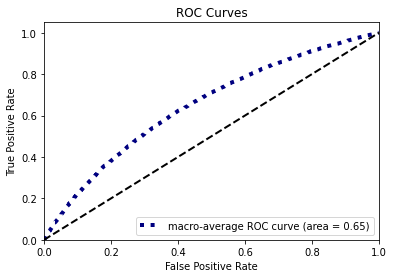

In [52]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([1-y_proba, y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Only GA

In [53]:
staged_probas_df, model_KU = train_model(df=df, cols=ga,
                                          folds=4, iterations=500, \
                                          depth=4, learning_rate=0.01)

table = model_KU.get_feature_importance(prettified=True)
table.to_excel('tables/FEATURE_IMPORTANCE_ga.xls')
table

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/tmp/ipykernel_11249/1849790312.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/FEATURE_IMPORTANCE_ga.xls')


,Feature Id,Importances
0,age,79.893115
1,gender,20.106885


In [54]:
table = get_result_table(staged_probas_df[449])
table.to_excel('tables/ga.xls')
table

[0.04645364278788313, 0.12493264867088112, 0.19808477269625355, 0.23332628973624625, 0.27468885429495327, 0.4447769012824268]


/tmp/ipykernel_11249/3053402939.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/ga.xls')


,y proba,Количество людей,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.046454,7006,19.966940,3.140166,19.65816
1,0.124933,6995,19.935591,6.175840,17.79637
2,0.198085,7005,19.964090,8.379729,17.55816
3,0.233326,6961,19.838691,10.530096,13.14050
4,0.274689,7100,20.234838,12.239437,12.09355
5,0.444777,0,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


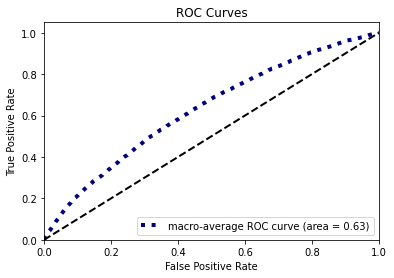

In [55]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([1-y_proba, y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Only anketas

In [56]:
staged_probas_df, model_KU = train_model(df=df, cols=anketas,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

table = model_KU.get_feature_importance(prettified=True)
table.to_excel('tables/FEATURE_IMPORTANCE_anketas.xls')
table

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/tmp/ipykernel_11249/2701872087.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/FEATURE_IMPORTANCE_anketas.xls')


,Feature Id,Importances
0,source,52.364939
1,job,24.204021
2,marital_status,13.691799
3,education,8.597336
4,childs,1.141905


In [57]:
table = get_result_table(staged_probas_df[449])
table.to_excel('tables/anketas.xls')
table

[0.05714183932548, 0.11460297597602896, 0.15072806013112441, 0.2047655608524197, 0.270245552945892, 0.6339587518759644]


/tmp/ipykernel_11249/300002434.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/anketas.xls')


,y proba,Количество людей,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.057142,6986,19.909941,2.619525,19.15856
1,0.114603,7016,19.995440,4.361460,18.28903
2,0.150728,7049,20.089489,6.227834,17.60711
3,0.204766,7019,20.003990,9.702237,14.56645
4,0.270246,7017,19.998290,17.614365,10.64789
5,0.633959,0,0.000000,NaN,0.00000


/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


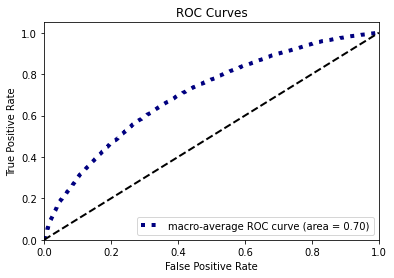

In [58]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([1-y_proba, y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Features

In [59]:
staged_probas_df, model_KU = train_model(df=df, cols=features,
                                          folds = 4, iterations=500, \
                                          depth=4, learning_rate=0.01)

table = model_KU.get_feature_importance(prettified=True)
table.to_excel('tables/FEATURE_IMPORTANCE_features.xls', encoding="utf-8")
table

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

26316 8772


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/tmp/ipykernel_11249/1659163661.py:6: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/FEATURE_IMPORTANCE_features.xls', encoding="utf-8")


,Feature Id,Importances
0,Полнота нижней губы,16.479664
1,Оттопыренность ушей,9.232384
2,Ширина челюсти,8.067019
3,Верхнее веко,7.495177
4,Скулы,4.860432
5,Размер рта,4.654621
6,Высота бровей,4.631543
7,Размер глаз,4.593112
8,Асимметрия размера глаз,4.548628
9,Полнота верхней губы,4.295673


In [60]:
table = get_result_table(staged_probas_df[449])
table.to_excel('tables/features.xls')
table

[0.10360770743942616, 0.17487917347547421, 0.1964277773021463, 0.2167636734552377, 0.24109101206910774, 0.36038746485021594]


/tmp/ipykernel_11249/4270422273.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  table.to_excel('tables/features.xls')


,y proba,Количество людей,"Процент людей, %","Процент мошенников в группе, %","Прибыль, млн.р"
0,0.103608,7018,20.00114,4.972927,19.51497
1,0.174879,7017,19.99829,6.170728,17.36464
2,0.196428,7018,20.00114,8.007979,15.63530
3,0.216764,7014,19.98974,9.538067,15.16622
4,0.241091,7020,20.00684,11.851852,12.58765
5,0.360387,0,0.00000,NaN,0.00000


/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


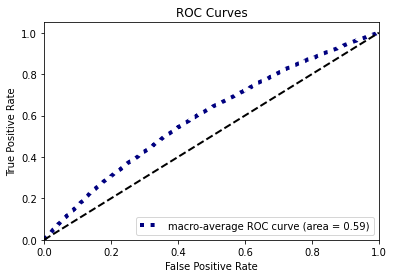

In [61]:
# Micro is shows more positive result
y_proba = staged_probas_df[499]
proba = np.array([1-y_proba, y_proba])
skplt.metrics.plot_roc_curve(df['target'].astype(int).values, proba.T, curves=['macro'])
plt.show()

# Try with LinearRegression

In [62]:
df['gender'] = df['gender'].replace({'Мужской': 1, 'Женский': 0})

/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/tmp/ipykernel_11249/419027857.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
/home/nikolay/anaconda3/envs/peller/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown

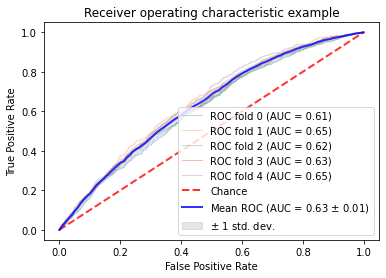

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from scipy import interp

n_samples, n_features = df.shape

cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(class_weight ='balanced', C=2.0, penalty='l2', solver='lbfgs')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
columns = features+ga#+anketas

i = 0
X, y = df[columns].values, df['target'].values
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [64]:
columns

['Асимметрия челюсти',
 'Высота бровей',
 'Наклон глаз',
 'Полнота верхней губы',
 'Полнота нижней губы',
 'Асимметрия размера глаз',
 'Ширина посадки глаз',
 'Скулы',
 'Форма головы',
 'Верхнее веко',
 'Асимметрия брови',
 'Наклон бровей',
 'Размер рта',
 'Асимметрия наклона глаз',
 'Асимметрия носа',
 'Размер глаз',
 'Оттопыренность ушей',
 'Ширина челюсти',
 'Уголки рта',
 'age',
 'gender']